In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## đọc dữ liệu

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/nam3/course/nlp/keras-text-summarization/demo/data/data_train.csv', encoding='utf-8')
df_dev = pd.read_csv('/content/drive/MyDrive/nam3/course/nlp/keras-text-summarization/demo/data/data_val.csv', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/nam3/course/nlp/keras-text-summarization/demo/data/test_data.csv', encoding='utf-8')


In [ ]:
#so sanh
set_test = pd.read_csv('/content/drive/MyDrive/nam3/course/nlp/keras-text-summarization/demo/data/test_data.csv', encoding='utf-8')

In [ ]:
set_test = set_test.drop(['Unnamed: 0', 'file'], axis=1)

In [ ]:
# set_test = set_test[0:10000]

In [ ]:
df_train = df_train.drop(['Unnamed: 0', 'file'], axis=1)
df_dev = df_dev.drop(['Unnamed: 0', 'file'], axis=1)
df_test = df_test.drop(['Unnamed: 0', 'file'], axis=1)

In [ ]:
df_train = df_train[0:50000]
df_dev = df_dev[0:10000]
# data_20k = train_df[0:20000]
# df_test = df_test[0:10000]

In [ ]:
df_train = df_train[0:80000]
df_dev = df_dev[0:20000]
# data_20k = train_df[0:20000]
df_test = df_test[0:20000]

In [ ]:
df_test.head(2)

,original,summary
0,HMS Queen_Elizabeth thử_nghiệm trên biển hồi n...,Bộ_trưởng Quốc_phòng Anh vạch ra chiến_lược hậ...
1,Bộ_trưởng Công_Thương_Trần_Tuấn_Anh vừa kỷ_luậ...,Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chín...


In [ ]:
df_train['summary'][1]

'USS Michigan , tàu_ngầm hạt_nhân Mỹ tới cảng Busan của Hàn_Quốc giữa khi căng_thẳng leo_thang trên bán_đảo Triều_Tiên . Động_thái này được cho là nhằm gia_tăng áp_lực lên Bình_Nhưỡng . '

##load word embedding

In [ ]:
EMBEDDING = '/content/drive/MyDrive/nam3/course/nlp/word2vec_vi_words_100dims.txt'
EMBEDING_DIM = 100
MAX_FEATURE = 10000
word_dict = []
embeddings_index = {}
embedding_dim = EMBEDING_DIM
max_feature = MAX_FEATURE
f = open(EMBEDDING)
for line in f:
  values = line.split(' ')
  word = values[0]
  word_dict.append(word)
  try:
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  except Exception as e:
    pass
f.close()
print('Embedding data loaded')

Embedding data loaded


In [ ]:
words = word_dict
num_words = len(words)
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0
# Dictionary lable:index pair
idx2word = {i: w for w, i in word_to_index.items()}

In [ ]:
import numpy as np
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer lets try to find that work in our w2v model
word_to_index

for word, i in word_to_index.items():
  if i > max_feature:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
  # add that words vector to the matrix
    embedding_matrix[i] = embedding_vector
  else:
    # doesn't exist, assign a random vector
    embedding_matrix[i] = np.random.randn(embedding_dim)
  

In [ ]:
!pip install vncorenlp -qq


     |████████████████████████████████| 2.6 MB 5.0 MB/s 


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2021-12-20 15:19:17--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   157MB/s    in 0.2s    

2021-12-20 15:19:17 (157 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-12-20 15:19:17--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar",annotators="wseg", max_heap_size='-Xmx500m')
def custom_tokenizer(text_data, tokenizer=True):
  if tokenizer:
    return " ".join(vncorenlp.tokenize(str(text_data))[0])
  return text_data


In [ ]:
from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
MAX_LEN = 100
# NUM_LABEL = 3
TOKENIZER = False
def encodingX(X):
  sentences = []

  for t in X:
    sentences.append(custom_tokenizer(t,tokenizer=TOKENIZER))
  X = []
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word_to_index[w])
      except:
        sent.append(word_to_index["UNK"])
    X.append(sent)

  X = pad_sequences(maxlen = MAX_LEN, sequences = X,padding = "post", value = word_to_index["PAD"])
  # y = pad_sequences(maxlen = MAX_LEN, sequences = X,padding = "post", value = word_to_index["PAD"])
  return (X)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
MAX_LEN = 100
# NUM_LABEL = 3
TOKENIZER = False
def encodingY(Y):
  sentences = []

  for t in Y:
    sentences.append(custom_tokenizer(t,tokenizer=TOKENIZER))
  y = []
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word_to_index[w])
      except:
        sent.append(word_to_index["UNK"])
    y.append(sent)

  y = pad_sequences(maxlen = MAX_LEN, sequences = y,padding = "post", value = word_to_index["PAD"])
  # y = pad_sequences(maxlen = MAX_LEN, sequences = X,padding = "post", value = word_to_index["PAD"])
  return (y)

In [ ]:
# X_train_encoded = encoding(X_train)
# X_dev_encoded = encoding(X_dev)
# X_test_encoded = encoding(X_test)

X_train_encoded = encodingX(df_train.original.values.flatten())
y_train_encoded = encodingY(df_train.summary)
X_dev_encoded = encodingX(df_dev.original.values.flatten())
y_dev_encoded = encodingY(df_dev.summary)
X_test_encoded = encodingX(df_test.original.values.flatten())
y_test_encoded = encodingY(df_test.summary)

In [ ]:
X_train_encoded.shape

(50000, 100)

## word embedding

In [ ]:
!pip install pyvi

In [ ]:
# Building dictionary 
word_to_index = {w : (i+2) for i, w in enumerate(V)}

word_to_index['UNK'] = 1
word_to_index['PAD'] = 0

# Build index2w
index_to_word = {i: w for w, i in word_to_index.items()}

In [ ]:
df_dev.head()

,original,summary
0,"CTCP Bóng đèn Điện_Quang ( mã chứng_khoán : DQC ) đã thông_qua Nghị_quyết Hội_đồng_quản_trị ( HĐQT ) về việc tạm_ứng cổ_tức đợt 1/2017. Cụ_thể , cổ_tức sẽ được trả bằng tiền_mặt với tỷ_lệ 15 % , t...","sostok Theo kế_hoạch trả cổ_tức đợt 1 năm 2017 của công_ty_Cổ_phần Bóng đèn Điện_Quang ( DQC ) , gia_đình bà Hồ_Thị_Kim_Thoa , cựu Thứ_trưởng bộ Công_Thương sắp được nhận gần 18 tỷ đồng_tiền cổ_tứ..."
1,"Nhấn_mạnh vai_trò đồng_hành , thầy Đoàn_Hồng_Hà , giáo_viên vật_lý Trường THPT chuyên Lê_Hồng_Phong , cho_rằng không phải một tiết có ba giáo_viên tham_gia là thành STEM . Giáo_viên phải cùng học ...","sostok Dạy_học STEM như_thế_nào , thầy_trò đã đi đúng hướng chưa ? Đó là trăn_trở của nhiều giáo_viên , lãnh_đạo trường THPT trên địa_bàn quận 5 , TP. HCM chia_sẻ tại buổi sơ_kết diễn ra ngày 16-5..."
2,"Tuần_san Times_Higher_Education , Anh công_bố bảng xếp_hạng đại_học ( ĐH ) tốt nhất toàn_cầu ( World_University_Rankings 2019 ) ngày 26-9 , theo đó ĐH Oxford ( Anh ) vẫn giữ ngôi quán quân và ĐH C...","sostok Trong bảng xếp_hạng các trường đại_học tốt nhất thế_giới năm 2019 , Đại_học Thanh_Hoa , Trung_Quốc đứng thứ 22 và là đại_học tốt nhất châu Á. eostok"
3,"Thông_báo kết_luận này được gửi đến tất_cả các sở , ban , ngành TP , UBND các quận_huyện trên địa_bàn TP , là cơ_sở pháp_lý chính_thức để các đơn_vị tiếp_tục thực_hiện các khâu đánh_giá hiệu_quả c...","sostok Chiều 8-7 , Văn_phòng UBND TP. HCM đã ban_hành thông_báo kết_luận của Thường_trực UBND TP liên_quan đến việc điều_chỉnh Quyết_định 4631 về đánh_giá , phân_loại hàng quý theo hiệu_quả công_v..."
4,"Vụ_việc một_số phụ_huynh phát_hiện thịt lợn nổi đầy hạch trắng , có dấu_hiệu của bệnh sán gạo trong bữa ăn của trẻ tại trường mầm_non xã Thanh_Khương , huyện Thuận_Thành , Bắc_Ninh và sau đó hơn 1...","sostok Liên_quan đến vụ hơn 100 trẻ nhiễm sán lợn ở Bắc_Ninh , ĐBQH – nhà_giáo , PGS.TS Hoàng_Văn_Cường cho_rằng , đó chính là tội_ác và cần phải truy đến cùng trách_nhiệm của những người liên_qua..."


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100
word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(df_train.original)

word_2_index = word_tokenizer.word_index
word_2_index['pad'] = 0
word_2_index['unk'] = -1

index_to_word = {i: w for w, i in word_to_index.items()}

def encodingX(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_2_index['pad'])

    return X

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100
yword_tokenizer = Tokenizer(oov_token=-1)
yword_tokenizer.fit_on_texts(df_train.summary)

yword_2_index = word_tokenizer.word_index
yword_2_index['pad'] = 0
yword_2_index['unk'] = -1

yindex_to_word = {i: w for w, i in yword_to_index.items()}

def encodingy(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = yword_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = yword_2_index['pad'])

    return X

NameError: ignored

In [ ]:
len(index_to_word)

80090

In [ ]:
word_2_index['làm_việc']

In [ ]:
X_train_encoded = encodingX(df_train.original.values.flatten())
y_train_encoded = encodingY(df_train.summary)
X_dev_encoded = encodingX(df_dev.original.values.flatten())
y_dev_encoded = encodingY(df_dev.summary)
X_test_encoded = encodingX(df_test.original.values.flatten())
y_test_encoded = encodingY(df_test.summary)


## pretrained

In [ ]:
#Add sostok and eostok at 
# post_pre_train = df_train
# post_pre_dev = df_dev
# post_pre_test = df_test
df_train['summary'] = df_train['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_dev['summary'] = df_dev['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eosto')

In [ ]:
!pip install pyvi

In [ ]:
# Read embedding
word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = len(embeddings_index) + 2

f = open('drive/MyDrive/public_dataset/uit-vsfc/W2V_ner.vec')
for line in f:
    values = line.split(' ')
    word = values[0] 
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

print('Embedding data loaded')

Embedding data loaded


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(df_train.original.values.flatten())
word_to_index = word_tokenizer.word_index
word_to_index['pad'] = 0
word_to_index['unk'] = -1

index_to_word = {i: w for w, i in word_to_index.items()}

def encodingx(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index['pad'])

    return X

In [ ]:
word_to_index['tôi']

85

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

yword_tokenizer = Tokenizer(oov_token=-1)
yword_tokenizer.fit_on_texts(df_train.summary.values.flatten())
yword_to_index = yword_tokenizer.word_index
yword_to_index['pad'] = 0
yword_to_index['unk'] = -1

yindex_to_word = {i: w for w, i in yword_to_index.items()}

def encodingy(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = yword_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = yword_to_index['pad'])

    return X

In [ ]:
# first create a matrix of zeros, this is our embedding matrix
import numpy as np

num_words = len(word_to_index)
embedding_matrixX = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixX[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixX[i] = np.random.randn(embedding_dim)

In [ ]:
# first create a matrix of zeros, this is our embedding matrix
ynum_words = len(yword_to_index)
embedding_matrixy = np.zeros((ynum_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in yword_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixy[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixy[i] = np.random.randn(embedding_dim)

In [ ]:
# X_train_encoded = encoding(X_train)
# X_dev_encoded = encoding(X_dev)
# X_test_encoded = encoding(X_test)

X_train_encoded = encodingx(df_train.original.values.flatten())
y_train_encoded = encodingy(df_train.summary)
X_dev_encoded = encodingx(df_dev.original.values.flatten())
y_dev_encoded = encodingy(df_dev.summary)
X_test_encoded = encodingx(df_test.original.values.flatten())
y_test_encoded = encodingy(df_test.summary)

In [ ]:
y_test_encoded[0]

array([   2,   33,  155,   19,  124,  140, 3039,   29,  160, 1035,  467,
       2585,  142,  126, 2595,  691,  515,  312,   85,   66,   24,  230,
        479,  505, 1275,    4, 1518,    1,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

array([[   2,   33,  155, ...,    0,    0,    0],
       [   2,  114,  500, ...,    0,    0,    0],
       [   2,  122,  282, ...,    0,    0,    0],
       ...,
       [   2,  340, 1712, ...,    0,    0,    0],
       [   2,   39, 1328, ...,    0,    0,    0],
       [   2,  108,  536, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#Adding Custom Attention layer 

import tensorflow as tf
import os
from keras.layers import Layer
from keras import backend as K


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## build model

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
num_wordsX = len(word_to_index)
num_wordsy = len(yword_to_index)

print("Size of vocabulary from the w2v model = {}".format(num_wordsX))
MAX_LEN=100
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(MAX_LEN, ))

#embedding layer
enc_emb =  Embedding(input_dim=num_wordsX, 
                     output_dim=embedding_dim,
                    #  embeddings_initializer=Constant(embedding_matrixX),
                     trainable=True,
                     input_length = MAX_LEN
                     
                     )(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(input_dim=num_wordsy,
                          output_dim=embedding_dim,
                          trainable=True,
                          # embeddings_initializer=Constant(embedding_matrixy),
                          input_length=MAX_LEN)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(num_wordsy, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 70132
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     7013200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                

In [ ]:
embedding_matrixX.shape

(70132, 300)

In [ ]:
X_train_encoded.shape

(50000, 100)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


## visualize model

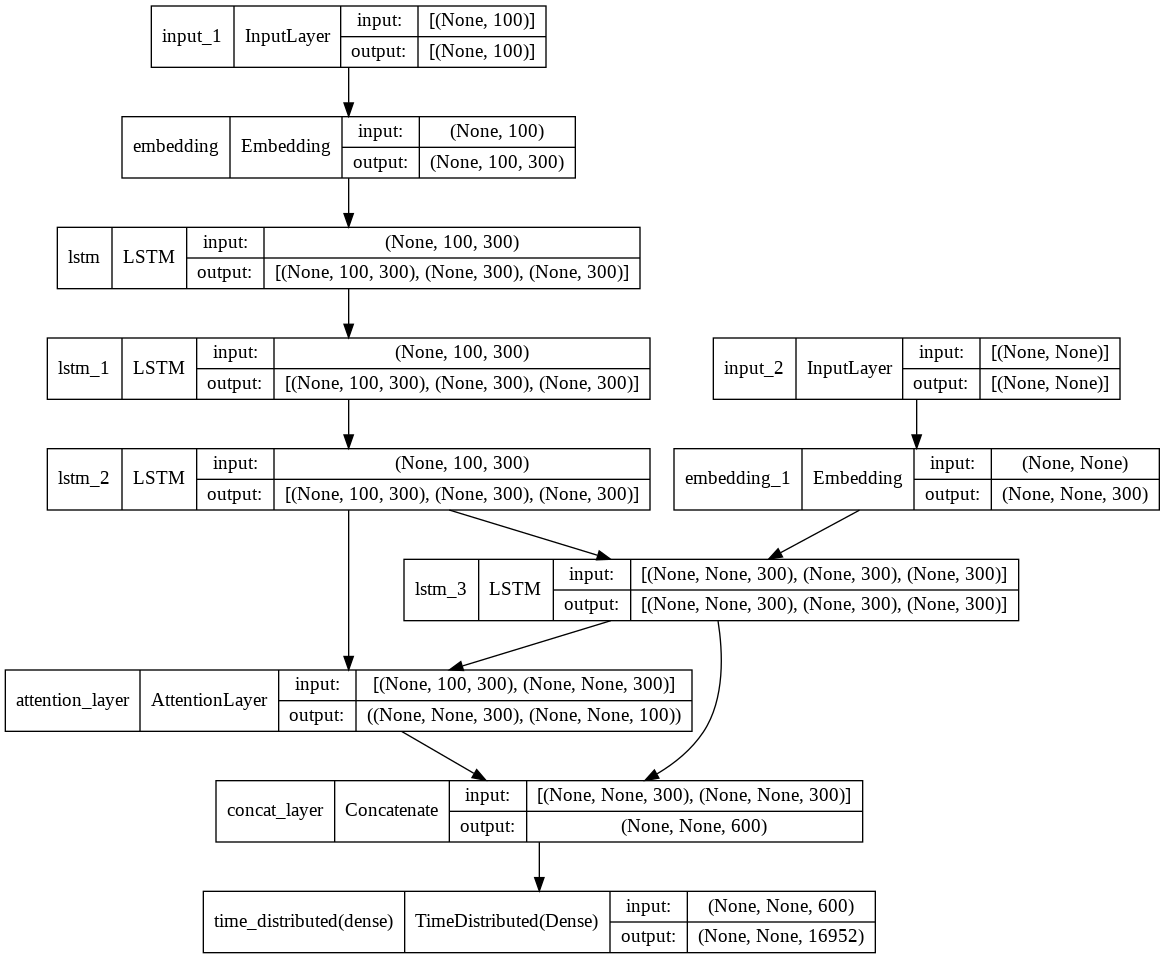

In [ ]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train model

In [ ]:
# history=model.fit(x_tr, y_tr,epochs=50,callbacks=[es],batch_size=128, validation_data=(x_val,y_val))

# history=model.fit([X_train_encoded,y_train_encoded[:,:]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
#                   epochs=50,callbacks=[es],
#                   batch_size=256, 
#                   validation_data=([X_dev_encoded,y_dev_encoded[:,:]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))

history=model.fit([X_train_encoded,y_train_encoded[:,:-1]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=256,
                  validation_data=([X_dev_encoded,y_dev_encoded[:,:-1]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))



Epoch 1/50
196/196 [==============================] - 518s 3s/step - loss: 2.6699 - val_loss: 2.4156
Epoch 2/50
196/196 [==============================] - 500s 3s/step - loss: 2.3409 - val_loss: 2.2498
Epoch 3/50
196/196 [==============================] - 499s 3s/step - loss: 2.1808 - val_loss: 2.0840
Epoch 4/50
194/196 [============================>.] - ETA: 4s - loss: 2.0243

##decode

In [ ]:
reverse_target_word_index=yword_tokenizer.index_word
reverse_source_word_index=word_tokenizer.index_word
target_word_index=yword_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
with open('/content/drive/MyDrive/nam3/course/nlp/encoder_50_model.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('/content/drive/MyDrive/nam3/course/nlp/encoder_model_50_seq2seq_vitokenizer.h5')

with open('/content/drive/MyDrive/nam3/course/nlp/decoder_50_model.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('/content/drive/MyDrive/nam3/course/nlp/decoder_model_50_seq2seq_vitokenizer.h5')

**We are defining a function below which is the implementation of the inference process**

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (100-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+str(reverse_target_word_index[i])+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+str(reverse_source_word_index[i])+' '
    return newString

**Run the model over the data to see the results**

### predict

In [ ]:
!pip install rouge-score -qq

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
for i in range(0,10):
    print("Review:",seq2text(X_test_encoded[i]))
    print("Original summary:",seq2summary(y_test_encoded[i]))
    print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    scores = scorer.score(seq2summary(y_test_encoded[i]), decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(scores)
    print("\n")


Review: kiến được trang bị hệ thống phóng và cáp hãm đà cho máy bay như lớp nimitz và gerald r ford của mỹ nhưng chi phí quá cao buộc hải quân anh lựa chọn giải pháp stovl và sử dụng tiêm kích f 35 b hms queen elizabeth có khả năng chở tối đa 36 máy bay f 35 b và 4 trực thăng cảnh báo sớm crowsnest nó có thể được bổ sung tới 12 trực thăng chinook hoặc merlin và 8 trực thăng tấn công ah 64 apache hms queen elizabeth thử nghiệm trên biển hồi năm 2018 
Original summary: bộ trưởng quốc phòng anh vạch ra chiến lược hậu brexit đề cao phô trương sức mạnh quân sự để bảo vệ lợi ích của london -1 
Predicted summary:  một tiêm kích f 35 a của mỹ đã bị tiêu diệt trong khi chiếc máy bay không người lái của mỹ và mỹ bắn hạ một máy bay
{'rouge1': Score(precision=0.3953488372093023, recall=0.4358974358974359, fmeasure=0.41463414634146334), 'rouge2': Score(precision=0.07142857142857142, recall=0.07894736842105263, fmeasure=0.075), 'rougeL': Score(precision=0.20930232558139536, recall=0.2307692307692307

In [ ]:
set_test.summary[0:10]

0                                                                                Bộ_trưởng Quốc_phòng Anh vạch ra chiến_lược hậu Brexit , đề_cao phô_trương sức_mạnh quân_sự để bảo_vệ lợi_ích của London . 
1    Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chính , Giám_đốc trung_tâm hỗ_trợ xuất_khẩu ( Cục Xúc_tiến thương_mại ) bị hạ bậc lương . Hội_đồng_kỷ_luật cũng cảnh_cáo 7 cán_bộ cấp phòng , khiển_trách ...
2           Theo quy_định của luật Khiếu_nại , các cơ_quan Nhà_nước có thẩm_quyền không được thụ_lý giải_quyết đối_với khiếu_nại đã có quyết_định giải_quyết lần 2 . Việc này thuộc thẩm_quyền của toà_án . 
3                                                                  Ngày mùng 3 Tết , phố Sách Hà_Nội mở_cửa và sẽ kéo_dài tới ngày mùng 10 tế và đây trở_thành một điểm đến của nhiều gia_đình đi du_xuân . 
4                                                                            Một cặp vợ_chồng tại thành_phố Hamburg , Đức đã lơ_đễnh quên mất đứa con vừa chào_đời của họ khi đi tax

In [ ]:
len(set_test.summary)

22644

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
df_predict_test = []
for i in range(len(set_test.summary)):
    # print("Review:",seq2text(X_test_encoded[i]))
    # print("Original summary:",seq2summary(y_test_encoded[i]))
    # print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    df_predict_test.append(decode_sequence(X_test_encoded[i].reshape(1,100)))
    scores = scorer.score(set_test.summary[i], decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(i)

In [ ]:
df_predict_test = pd.DataFrame(df_predict_test, columns = ['predict'])

In [ ]:
df_predict_test.to_csv('/content/drive/MyDrive/nam3/course/nlp/predict_full.csv', encoding='utf-8')

In [ ]:
from keras.models import model_from_json

# Load model and Predict

In [ ]:
from keras.models import model_from_json

In [ ]:
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read(), custom_objects={'AttentionLayer': AttentionLayer})
    model.load_weights(model_weights_filename)
    return model

encoder = load_model('/content/drive/MyDrive/nam3/course/nlp/encoder_50_model.json', '/content/drive/MyDrive/nam3/course/nlp/encoder_model_50_seq2seq_vitokenizer.h5')
decoder = load_model('/content/drive/MyDrive/nam3/course/nlp/decoder_50_model.json', '/content/drive/MyDrive/nam3/course/nlp/decoder_model_50_seq2seq_vitokenizer.h5')

In [ ]:
reverse_target_word_index=yword_tokenizer.index_word
reverse_source_word_index=word_tokenizer.index_word
target_word_index=yword_tokenizer.word_index

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (100-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+str(reverse_target_word_index[i])+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+str(reverse_source_word_index[i])+' '
    return newString

In [ ]:
!pip install -q rouge_score

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
for i in range(0,10):
    print("Review:",seq2text(X_test_encoded[i]))
    print("Original summary:",seq2summary(y_test_encoded[i]))
    print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    scores = scorer.score(seq2summary(y_test_encoded[i]), decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(scores)
    print("\n")

Review: kiến được trang bị hệ thống phóng và cáp hãm đà cho máy bay như lớp nimitz và gerald r ford của mỹ nhưng chi phí quá cao buộc hải quân anh lựa chọn giải pháp stovl và sử dụng tiêm kích f 35 b hms queen elizabeth có khả năng chở tối đa 36 máy bay f 35 b và 4 trực thăng cảnh báo sớm crowsnest nó có thể được bổ sung tới 12 trực thăng chinook hoặc merlin và 8 trực thăng tấn công ah 64 apache hms queen elizabeth thử nghiệm trên biển hồi năm 2018 
Original summary: bộ trưởng quốc phòng anh vạch ra chiến lược hậu brexit đề cao phô trương sức mạnh quân sự để bảo vệ lợi ích của london -1 
Predicted summary:  một tiêm kích f 35 a của mỹ đã bị tiêu diệt trong khi chiếc máy bay không người lái của mỹ và mỹ bắn hạ một máy bay
{'rouge1': Score(precision=0.3953488372093023, recall=0.4358974358974359, fmeasure=0.41463414634146334), 'rouge2': Score(precision=0.07142857142857142, recall=0.07894736842105263, fmeasure=0.075), 'rougeL': Score(precision=0.20930232558139536, recall=0.2307692307692307

In [ ]:
list_pred = []
for i in range(len(X_test_encoded)): 
    print("Predicted summary:", i)
    list_pred.append(decode_sequence(X_test_encoded[i].reshape(1,100)))


Predicted summary: 18974
Predicted summary: 18975
Predicted summary: 18976
Predicted summary: 18977
Predicted summary: 18978
Predicted summary: 18979
Predicted summary: 18980
Predicted summary: 18981
Predicted summary: 18982
Predicted summary: 18983
Predicted summary: 18984
Predicted summary: 18985
Predicted summary: 18986
Predicted summary: 18987
Predicted summary: 18988
Predicted summary: 18989
Predicted summary: 18990
Predicted summary: 18991
Predicted summary: 18992
Predicted summary: 18993
Predicted summary: 18994
Predicted summary: 18995
Predicted summary: 18996
Predicted summary: 18997
Predicted summary: 18998
Predicted summary: 18999
Predicted summary: 19000
Predicted summary: 19001
Predicted summary: 19002
Predicted summary: 19003
Predicted summary: 19004
Predicted summary: 19005
Predicted summary: 19006
Predicted summary: 19007
Predicted summary: 19008
Predicted summary: 19009
Predicted summary: 19010
Predicted summary: 19011
Predicted summary: 19012
Predicted summary: 19013


In [ ]:
data_pred = pd.DataFrame(list_pred, columns = ['Predict'])

In [ ]:
len(set_test)

22644

In [ ]:
bigdata = pd.concat([data_pred, set_test.summary], ignore_index=True, sort=False)

In [ ]:
bigdata

,Predict,0
0,một tiêm kích f 35 a của mỹ đã bị tiêu diệt trong khi chiếc máy bay không người lái của mỹ và mỹ bắn hạ một máy bay,NaN
1,ông nguyễn đức chung chủ tịch ubnd tỉnh quảng ninh đã quyết định kỷ luật cảnh cáo về hành động vi phạm quy định về hành vi vi phạm quy định về hành vi vi phạm quy định,NaN
2,sau khi nhận được thông tin về việc bổ sung tài sản của ông nguyễn hữu linh đã bị tố cáo buộc phải bồi thường cho các cá nhân liên quan đến vụ án,NaN
3,sáng 21 3 tại tp hcm đã tổ chức lễ hội pháo hoa quốc tế 2019 tại tp hcm và tp hcm đã được tổ chức tại tp hcm,NaN
4,chiếc taxi chở khách đi trên đường nguyễn văn trỗi quận gò vấp tp hcm đã va chạm với xe máy khiến nhiều người bị thương,NaN
...,...,...
45283,NaN,"Bộ_trưởng Bộ Công_an Tô_Lâm nhận_định TP. HCM đang bị tội_phạm biến thành nơi trung_chuyển ma_tuý do có rất nhiều sơ_hở trong quản_lý_nhà_nước , phải tháo_gỡ trong thời_gian tới ."
45284,NaN,Đây được xem là cuộc biểu_tình lớn nhất từ khi Hong_Kong được trao_trả cho Trung_Quốc nhằm phản_đối việc đưa tội_phạm tới đại_lục xét_xử .
45285,NaN,"Tổng_thống Mỹ Donald_Trump bình_luận rằng Trung_Quốc đã "" bóc_lột hàng tỉ đôla "" của Mỹ như "" lấy tiền của con_nít "" , tố cả chính_quyền các đời tổng_thống trước đều bị lừa ."
45286,NaN,Ba hoạ_sĩ trẻ có “ sự bùng_nổ trong sáng_tạo ” sẽ được lựa_chọn trở_thành những hoạ_sĩ Việt_Nam đầu_tiên tham_dự Hội_chợ nghệ_thuật ( Affordable_Art_Fair ) tại London tháng 5-2019 .


In [ ]:
data_pred.to_csv('predict_full.csv', encoding='utf-8')

In [ ]:
!pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
list_score = []
for i in range(0,len(set_test)):
    scores = scorer.score(bigdata.iloc[:,0][i],bigdata.iloc[:,1][i] )
    list_score.append(scores)
    print(scores)

In [ ]:
list_score_r1 = []
list_score_r2 = []
list_score_rl = []
for i in range(10000):
  list_score_r1.append(list_score[i]['rouge1'].fmeasure)
  list_score_r2.append(list_score[i]['rouge2'].fmeasure)
  list_score_rl.append(list_score[i]['rougeL'].fmeasure)

In [ ]:
np.mean(list_score_r1)

0.46739412426691196

In [ ]:
np.mean(list_score_r2)

0.11364088531719214

In [ ]:
np.mean(list_score_rl)

0.27981682056699375

In [ ]:
data_pred = pd.read_csv('/content/predict_full.csv')
data_pred.head(5)

,Unnamed: 0,Predict
0,0,một tiêm kích f 35 a của mỹ đã bị tiêu diệt t...
1,1,ông nguyễn đức chung chủ tịch ubnd tỉnh quảng...
2,2,sau khi nhận được thông tin về việc bổ sung t...
3,3,sáng 21 3 tại tp hcm đã tổ chức lễ hội pháo h...
4,4,chiếc taxi chở khách đi trên đường nguyễn văn...


In [ ]:
set_test.iloc[:,1][1]

'Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chính , Giám_đốc trung_tâm hỗ_trợ xuất_khẩu ( Cục Xúc_tiến thương_mại ) bị hạ bậc lương . Hội_đồng_kỷ_luật cũng cảnh_cáo 7 cán_bộ cấp phòng , khiển_trách 2 viên_chức . '

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
list_score = []
for i in range(0,len(set_test)):
    scores = scorer.score(data_pred.iloc[:,1][i],set_test.iloc[:,1][i] )
    list_score.append(scores)
    print(scores)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
{'rouge1': Score(precision=0.4090909090909091, recall=0.6, fmeasure=0.4864864864864865), 'rouge2': Score(precision=0.07692307692307693, recall=0.11363636363636363, fmeasure=0.09174311926605505), 'rougeL': Score(precision=0.21212121212121213, recall=0.3111111111111111, fmeasure=0.25225225225225223)}
{'rouge1': Score(precision=0.375, recall=0.4166666666666667, fmeasure=0.3947368421052631), 'rouge2': Score(precision=0.05128205128205128, recall=0.05714285714285714, fmeasure=0.05405405405405405), 'rougeL': Score(precision=0.225, recall=0.25, fmeasure=0.2368421052631579)}
{'rouge1': Score(precision=0.4489795918367347, recall=0.4782608695652174, fmeasure=0.46315789473684216), 'rouge2': Score(precision=0.1875, recall=0.2, fmeasure=0.19354838709677422), 'rougeL': Score(precision=0.30612244897959184, recall=0.32608695652173914, fmeasure=0.3157894736842105)}
{'rouge1': Score(precision=0.3956043956043956, recall=0.5294117647058824, fmeasure=

In [ ]:
list_score_r1 = []
list_score_r2 = []
list_score_rl = []
for i in range(len(set_test)):
  list_score_r1.append(list_score[i]['rouge1'].fmeasure)
  list_score_r2.append(list_score[i]['rouge2'].fmeasure)
  list_score_rl.append(list_score[i]['rougeL'].fmeasure)

In [ ]:
np.mean(list_score_r1)

0.4683713223489246

In [ ]:
np.mean(list_score_r2)

0.11435775415628803

In [ ]:
np.mean(list_score_rl)

0.280151845004623

In [ ]:
list_score_r1_pre = []
list_score_r2_pre = []
list_score_rl_pre = []
for i in range(len(set_test)):
  list_score_r1_pre.append(list_score[i]['rouge1'].precision)
  list_score_r2_pre.append(list_score[i]['rouge2'].precision)
  list_score_rl_pre.append(list_score[i]['rougeL'].precision)

In [ ]:
np.mean(list_score_r1_pre)

0.43200659285619114

In [ ]:
np.mean(list_score_r2_pre)

0.10511875833749815

In [ ]:
np.mean(list_score_rl_pre)

0.2586266782912943

In [ ]:
list_score_r1_recall = []
list_score_r2_recall = []
list_score_rl_recall = []
for i in range(len(set_test)):
  list_score_r1_recall.append(list_score[i]['rouge1'].recall)
  list_score_r2_recall.append(list_score[i]['rouge2'].recall)
  list_score_rl_recall.append(list_score[i]['rougeL'].recall)

In [ ]:
print(np.mean(list_score_r1_recall))
print(np.mean(list_score_r2_recall))
print(np.mean(list_score_rl_recall))

0.5420082146962527
0.1331715473517463
0.3247011593825895
